This notebook is for exploring different inputs for supervised machine learning models. 

In [1]:
# Import necessary packages
import os
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import earthpy as et
import earthpy.spatial as es

In [2]:
# For windows users
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [40]:
# Define area of interest and paths
aoi = 'koumassi_focus_ps'
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
svm_outputs_path = os.path.join(band_path, "outputs\\svm\\")

# Select all raw values needed for model development
raw_list = glob(raster_outputs_path+"\\"+"*raw*")
raw_list.sort()

# Read in validation data sets
# 60perc is for model training/testing, 40perc is for external validatin
validation_data_path = os.path.join(band_path, 'validation\\')
sample_pts_60perc = gpd.read_file(
    validation_data_path+"vector-data\\validation_points_koumassi_60_percent.shp")
sample_pts_40perc = gpd.read_file(
    validation_data_path+"vector-data\\validation_points_koumassi_40_percent.shp")

In [41]:
# Get meta data for writing out SVM result
all_bands_path = os.path.join(raster_outputs_path + aoi+"_all_bands.tif")
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
files_out_meta['count']=1

In [42]:
# Sample index values at reference points for 60perc data set

# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)

i = 0
index_list = []
filename=[]

for raw in raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords, y_coords)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[51:71])
        
labels = filename
index_df = pd.DataFrame(np.concatenate(index_list))
index_df = index_df.transpose()
index_df.columns=labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"raw_index_values_60perc.csv"
index_df.to_csv(filepath) 

In [43]:
# Create dataframe with  validation classes and index values
# Validation data CSV created using ArcGIS
valid_60_data = pd.read_csv(validation_data_path+"koumassi_validation_data_60_percent.csv")
train_data = pd.concat([valid_60_data,index_df], axis=1, sort=False)
train_data.head()

,OBJECTID,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal_msi.tif,ndwi_green_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,1,2,0.1706,0.005009,0.094227,-0.029991,-0.002122,-0.087033,0.043328,-0.050900
1,2,1,0.1616,0.002909,0.142139,-0.008547,-0.186688,-0.190664,-0.024164,-0.166302
2,3,1,0.1767,0.000000,0.169791,-0.016337,-0.306197,-0.239764,-0.021997,-0.191788
3,4,1,0.2070,0.001309,0.183048,0.032749,-0.376951,-0.288930,-0.056972,-0.240019
4,5,1,0.2110,0.000000,0.183052,0.013818,-0.291486,-0.266255,-0.056662,-0.239714


In [73]:
# Define training dataset
XX =train_data.iloc[:,[2,3,4,5,6,8,9]]
X = train_data.iloc[:,[2,3,4,5,6,8,9]].values
y = train_data.iloc[:,1].values
XX.head()

,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,0.1706,0.005009,0.094227,-0.029991,-0.002122,0.043328,-0.050900
1,0.1616,0.002909,0.142139,-0.008547,-0.186688,-0.024164,-0.166302
2,0.1767,0.000000,0.169791,-0.016337,-0.306197,-0.021997,-0.191788
3,0.2070,0.001309,0.183048,0.032749,-0.376951,-0.056972,-0.240019
4,0.2110,0.000000,0.183052,0.013818,-0.291486,-0.056662,-0.239714


In [74]:
# Split training dataset, test size is 40%, training size 60%
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [75]:
# Define SVC classifier with linear kernel. Run cells 8 and 9 until happy with accuracy score.
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

0.9256198347107438

In [70]:
# Save out SVM classifier with highest accuracy score. 

# Final SVM model saved with accuracy score of 0.9504132231404959
# Includes dark, MSI, NDVI, NDWIcoastal-MSI, NDWIgreen-MSI, NDWI_yellow
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final_with_ndvi_ndwi_yellow', 'wb'))

# Final SVM model saved with accuracy score of 0.9504132231404959
# Includes dark, MSI, NDVI, NDWIcoastal-MSI, NDWIgreen-MSI
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final_with_ndvi', 'wb'))

# Final SVM model saved with accuracy score of 0.0.9462809917355371
# Includes dark, MSI, NDVI, NDWIcoastal-MSI, NDWIgreen-MSI
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final_no_mbi_ndvi', 'wb'))

# Final SVM model saved with accuracy score of 0.9545454545454546
# dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_green.tif 	ndwi_green_msi.tif 	ndwi_yellow.tif
# THIS WAS OVERWRITTEN BY MISTAKE. Needs updating.
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final_all_params', 'wb'))

# Final SVM model saved with accuracy score of 0.950413223140495
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final', 'wb'))

# Final SVM model saved with accuracy score of 0.946280991
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_final_old', 'wb'))

# Using updated version of sklearn for use with GBDX, updated pickled svm model.
# "pickle_svm_updated had accuracy of 95.45%
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm_updated', 'wb'))

# Previously dumped model with accuracy score of 95.868% includes:dark, mbi, msi, coastal-msi, green-msi
# pickle.dump(clf, open(svm_outputs_path+'pickle_svm', 'wb'))

In [15]:
# Define SVM classifier with rbf kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8140495867768595

In [12]:
 # Save out SVM classifier with rbf kernel, accuracy score of 0.8553719008264463
# pickle.dump(clf_rbf, open(svm_outputs_path+'pickle_svm_rbf_final_with_ndvi', 'wb'))

[[125   0   0]
 [  9  55   1]
 [  0   2  50]]


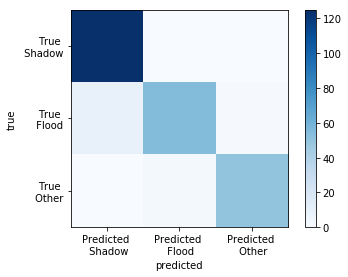

In [16]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

[[129   0   0]
 [ 32  29   0]
 [  1   3  48]]


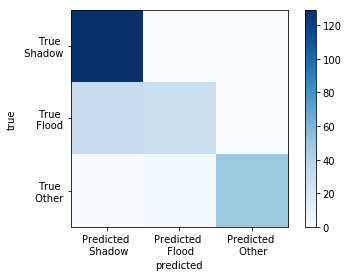

In [14]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(ytest, ypred_rbf))
plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Validation with 40% of data held back from SVM model development

In [52]:
# Create tuples of all x coordinates and y coordinates 
x_valid_coords = tuple(sample_pts_40perc.geometry.x)
y_valid_coords = tuple(sample_pts_40perc.geometry.y)

i = 0
index_valid_list = []
filename=[]

for raw in raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_valid_coords, y_valid_coords)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_valid_list.append([arr])
        filename.append(raw[50:78])
        

labels = filename
index_valid_df = pd.DataFrame(np.concatenate(index_valid_list))
index_valid_df = index_valid_df.transpose()
index_valid_df.columns=labels
filepath = validation_data_path+"raw_index_values_40perc.csv"
index_valid_df.to_csv(filepath) 

In [53]:
# Create dataframe with  validation classes and index values
# Validation data CSV created using ArcGIS
valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
external_valid_df = pd.concat([valid_40_data,index_valid_df], axis=1, sort=False)

In [77]:
# Define external validation dataset
XXvalid = external_valid_df.iloc[:,[2,3,4,5,6,8,9]]
Xvalid = external_valid_df.iloc[:,[2,3,4,5,6,8,9]].values
yvalid = external_valid_df.iloc[:,1].values
XXvalid.head()

,_dark.tif,_mbi.tif,_msi.tif,_ndvi.tif,_ndwi_coastal_msi.tif,_ndwi_yellow.tif,_ndwi_yellow_msi.tif
0,0.1846,0.001091,0.111064,-0.011570,-0.111863,0.000000,-0.111064
1,0.1630,0.000000,0.131636,0.006560,-0.237804,-0.013902,-0.145538
2,0.1916,0.000000,0.182211,0.021898,-0.350546,-0.039676,-0.221887
3,0.2337,0.001064,0.184959,0.252107,-0.517763,-0.237463,-0.422422
4,0.2469,0.000205,0.177216,0.025735,-0.416113,-0.035851,-0.213067


In [78]:
# Load saved SVM classifer
loaded_clf = pickle.load(open(svm_outputs_path+'pickle_svm_final_with_ndvi_ndwi_yellow', 'rb'))

# Apply linear kernel SVM classifier to external dataset
ypred_valid = clf.predict(Xvalid)
accuracy_score(yvalid, ypred_valid)

0.9106699751861043

[[206   3   0]
 [ 31  85   0]
 [  0   2  76]]


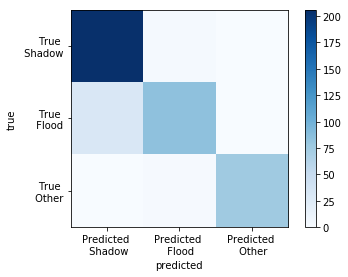

In [79]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(yvalid, ypred_valid))

plt.imshow(confusion_matrix(yvalid, ypred_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [20]:
# Write out confusion matrix array
confusion_svm_external = confusion_matrix(yvalid, ypred_valid)
pd.DataFrame(confusion_svm_external).to_csv(svm_outputs_path+'confusion_svm_external.csv')

In [21]:
# Load saved SVM classifer with rbf kernel
loaded_clf_rbf = pickle.load(open(svm_outputs_path+'pickle_svm_rbf_final_with_ndvi', 'rb'))
# Apply rbf kernel SVM classifier to external dataset
ypred_rbf_valid = loaded_clf_rbf.predict(Xvalid)
accuracy_score(yvalid, ypred_rbf_valid)

0.8188585607940446

[[209   0   0]
 [ 69  47   0]
 [  0   4  74]]


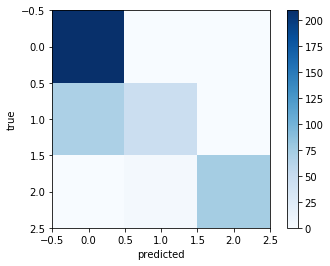

In [22]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(yvalid, ypred_rbf_valid))

plt.imshow(confusion_matrix(yvalid, ypred_rbf_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Developing map based on trained SVM model with linear kernel

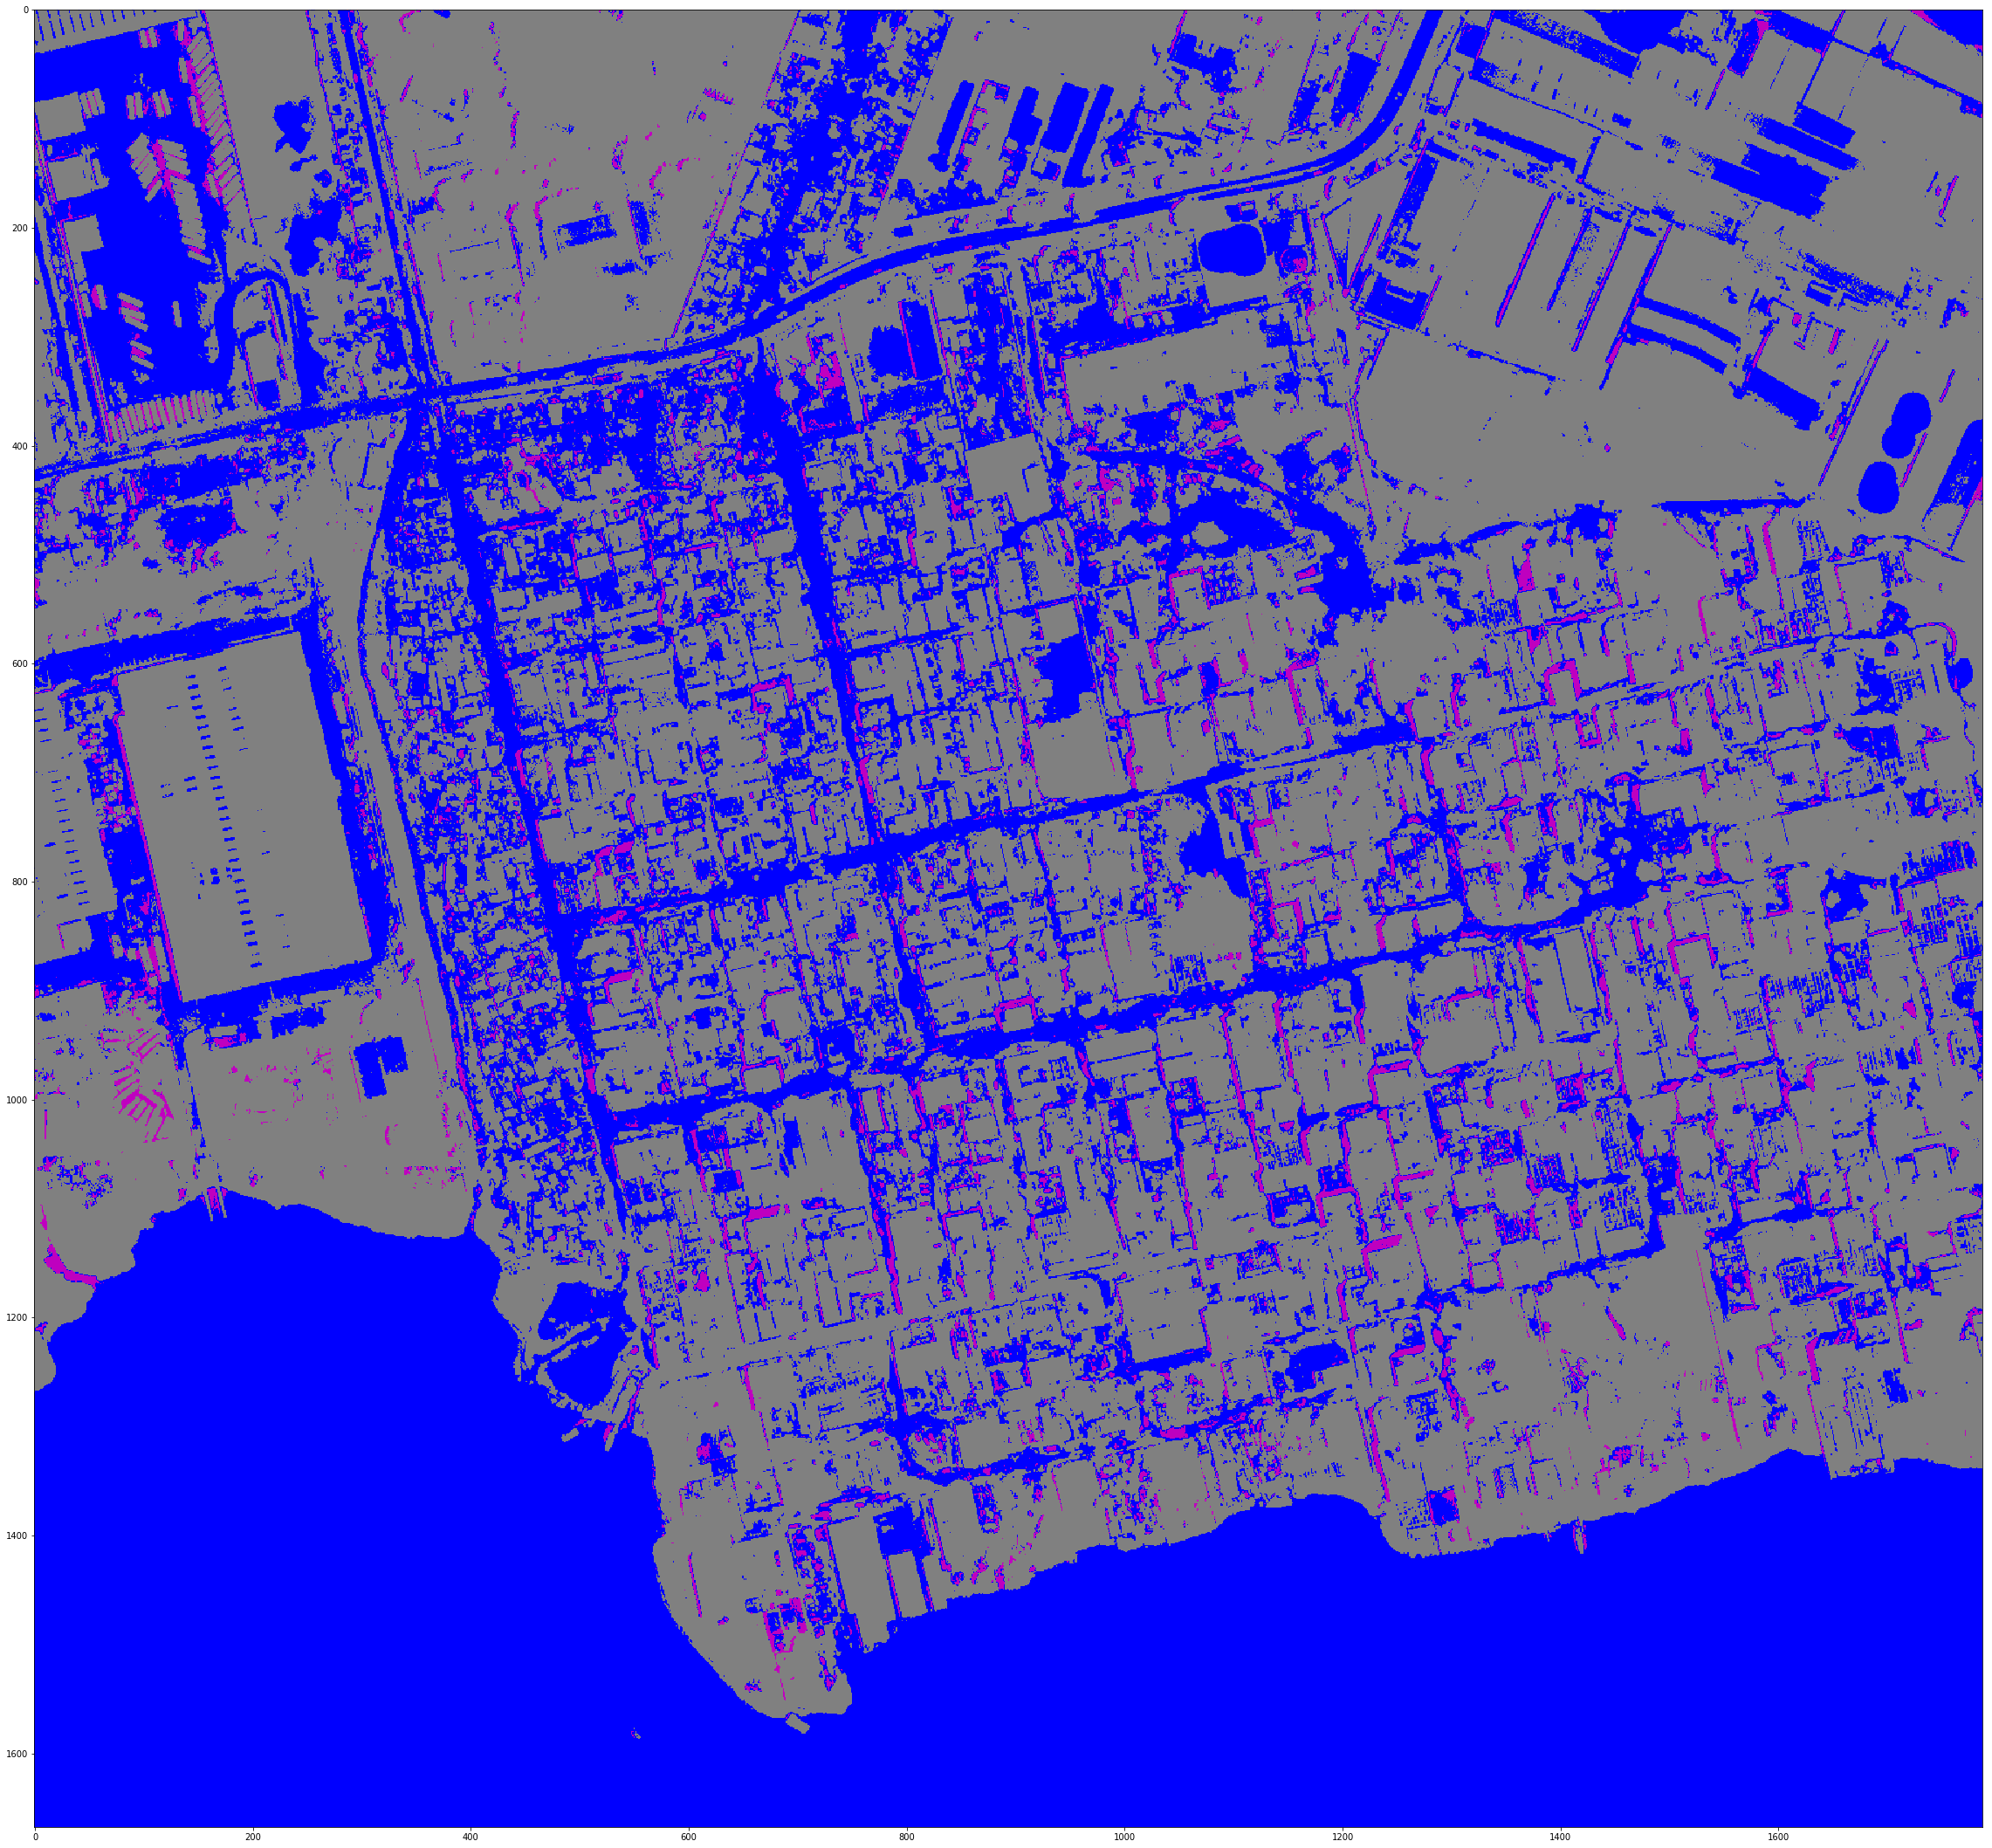

In [22]:
# Load saved SVM classifer
loaded_clf = pickle.load(open(svm_outputs_path+'pickle_svm_final_with_ndvi_ndwi_yellow', 'rb'))

# Create stack of inputs for entire image and apply saved linear SVM classifer
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,7) #Update based on number of model params
predictedClass = loaded_clf.predict(X_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()

In [24]:
# Write out SVM map
with rio.open(svm_outputs_path+'SVM_map.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

# Random forest

In [82]:
# Define random forest classifier
clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=10)

In [100]:
# Split training dataset, test size is 40%, training size 60%
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(X, y, test_size=0.4)

In [101]:
# Apply random forest classifier
clf_random_forest.fit(Xtrain_rf, ytrain_rf)
ypred_random_forest = clf_random_forest.predict(Xtest_rf)
accuracy_score(ytest_rf, ypred_random_forest)

0.9545454545454546

[[123   4   0]
 [  7  60   0]
 [  0   1  47]]


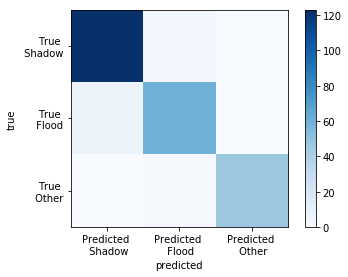

In [28]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_rf, ypred_random_forest))
plt.imshow(confusion_matrix(ytest_rf, ypred_random_forest),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [29]:
# Save out random forest classfier with accuracy score of 0.9462809917355371
pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_RF_final_with_ndvi', 'wb'))

# Save out random forest classfier with accuracy score of 0.946281
# pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_RF_final', 'wb'))

# picked 0.9545 accuracy score
# pickled 0.929752 model with better confusion matrix as "best" model confusion matrix did not look good

# pickled 0.9421487603305785 model with better confusion matrix 
# pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_random_forest_updated', 'wb'))

# Validation with 40% of data held back from random forest model development

In [86]:
# Load saved random forest classifer
loaded_clf_rf = pickle.load(open(svm_outputs_path+'pickle_RF_final_with_ndvi', 'rb'))

In [102]:
# Apply linear kernel random forest classifier to external dataset
ypred_valid_rf = clf_random_forest.predict(Xvalid)
accuracy_score(yvalid, ypred_valid_rf)

0.9205955334987593

[[199  10   0]
 [ 17  99   0]
 [  0   2  76]]


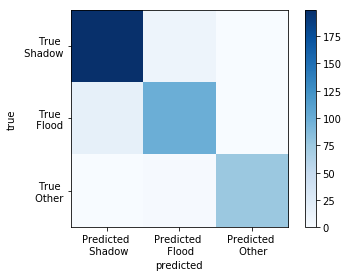

In [32]:
#Print confusion matrix for random forest
print(confusion_matrix(yvalid, ypred_valid_rf))

plt.imshow(confusion_matrix(yvalid, ypred_valid_rf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [33]:
# Write out confusion matrix 
confusion_rf_external = confusion_matrix(yvalid, ypred_valid)
pd.DataFrame(confusion_rf_external).to_csv(svm_outputs_path+'confusion_rf_external.csv')

# Plot random forest

[1 2 3]


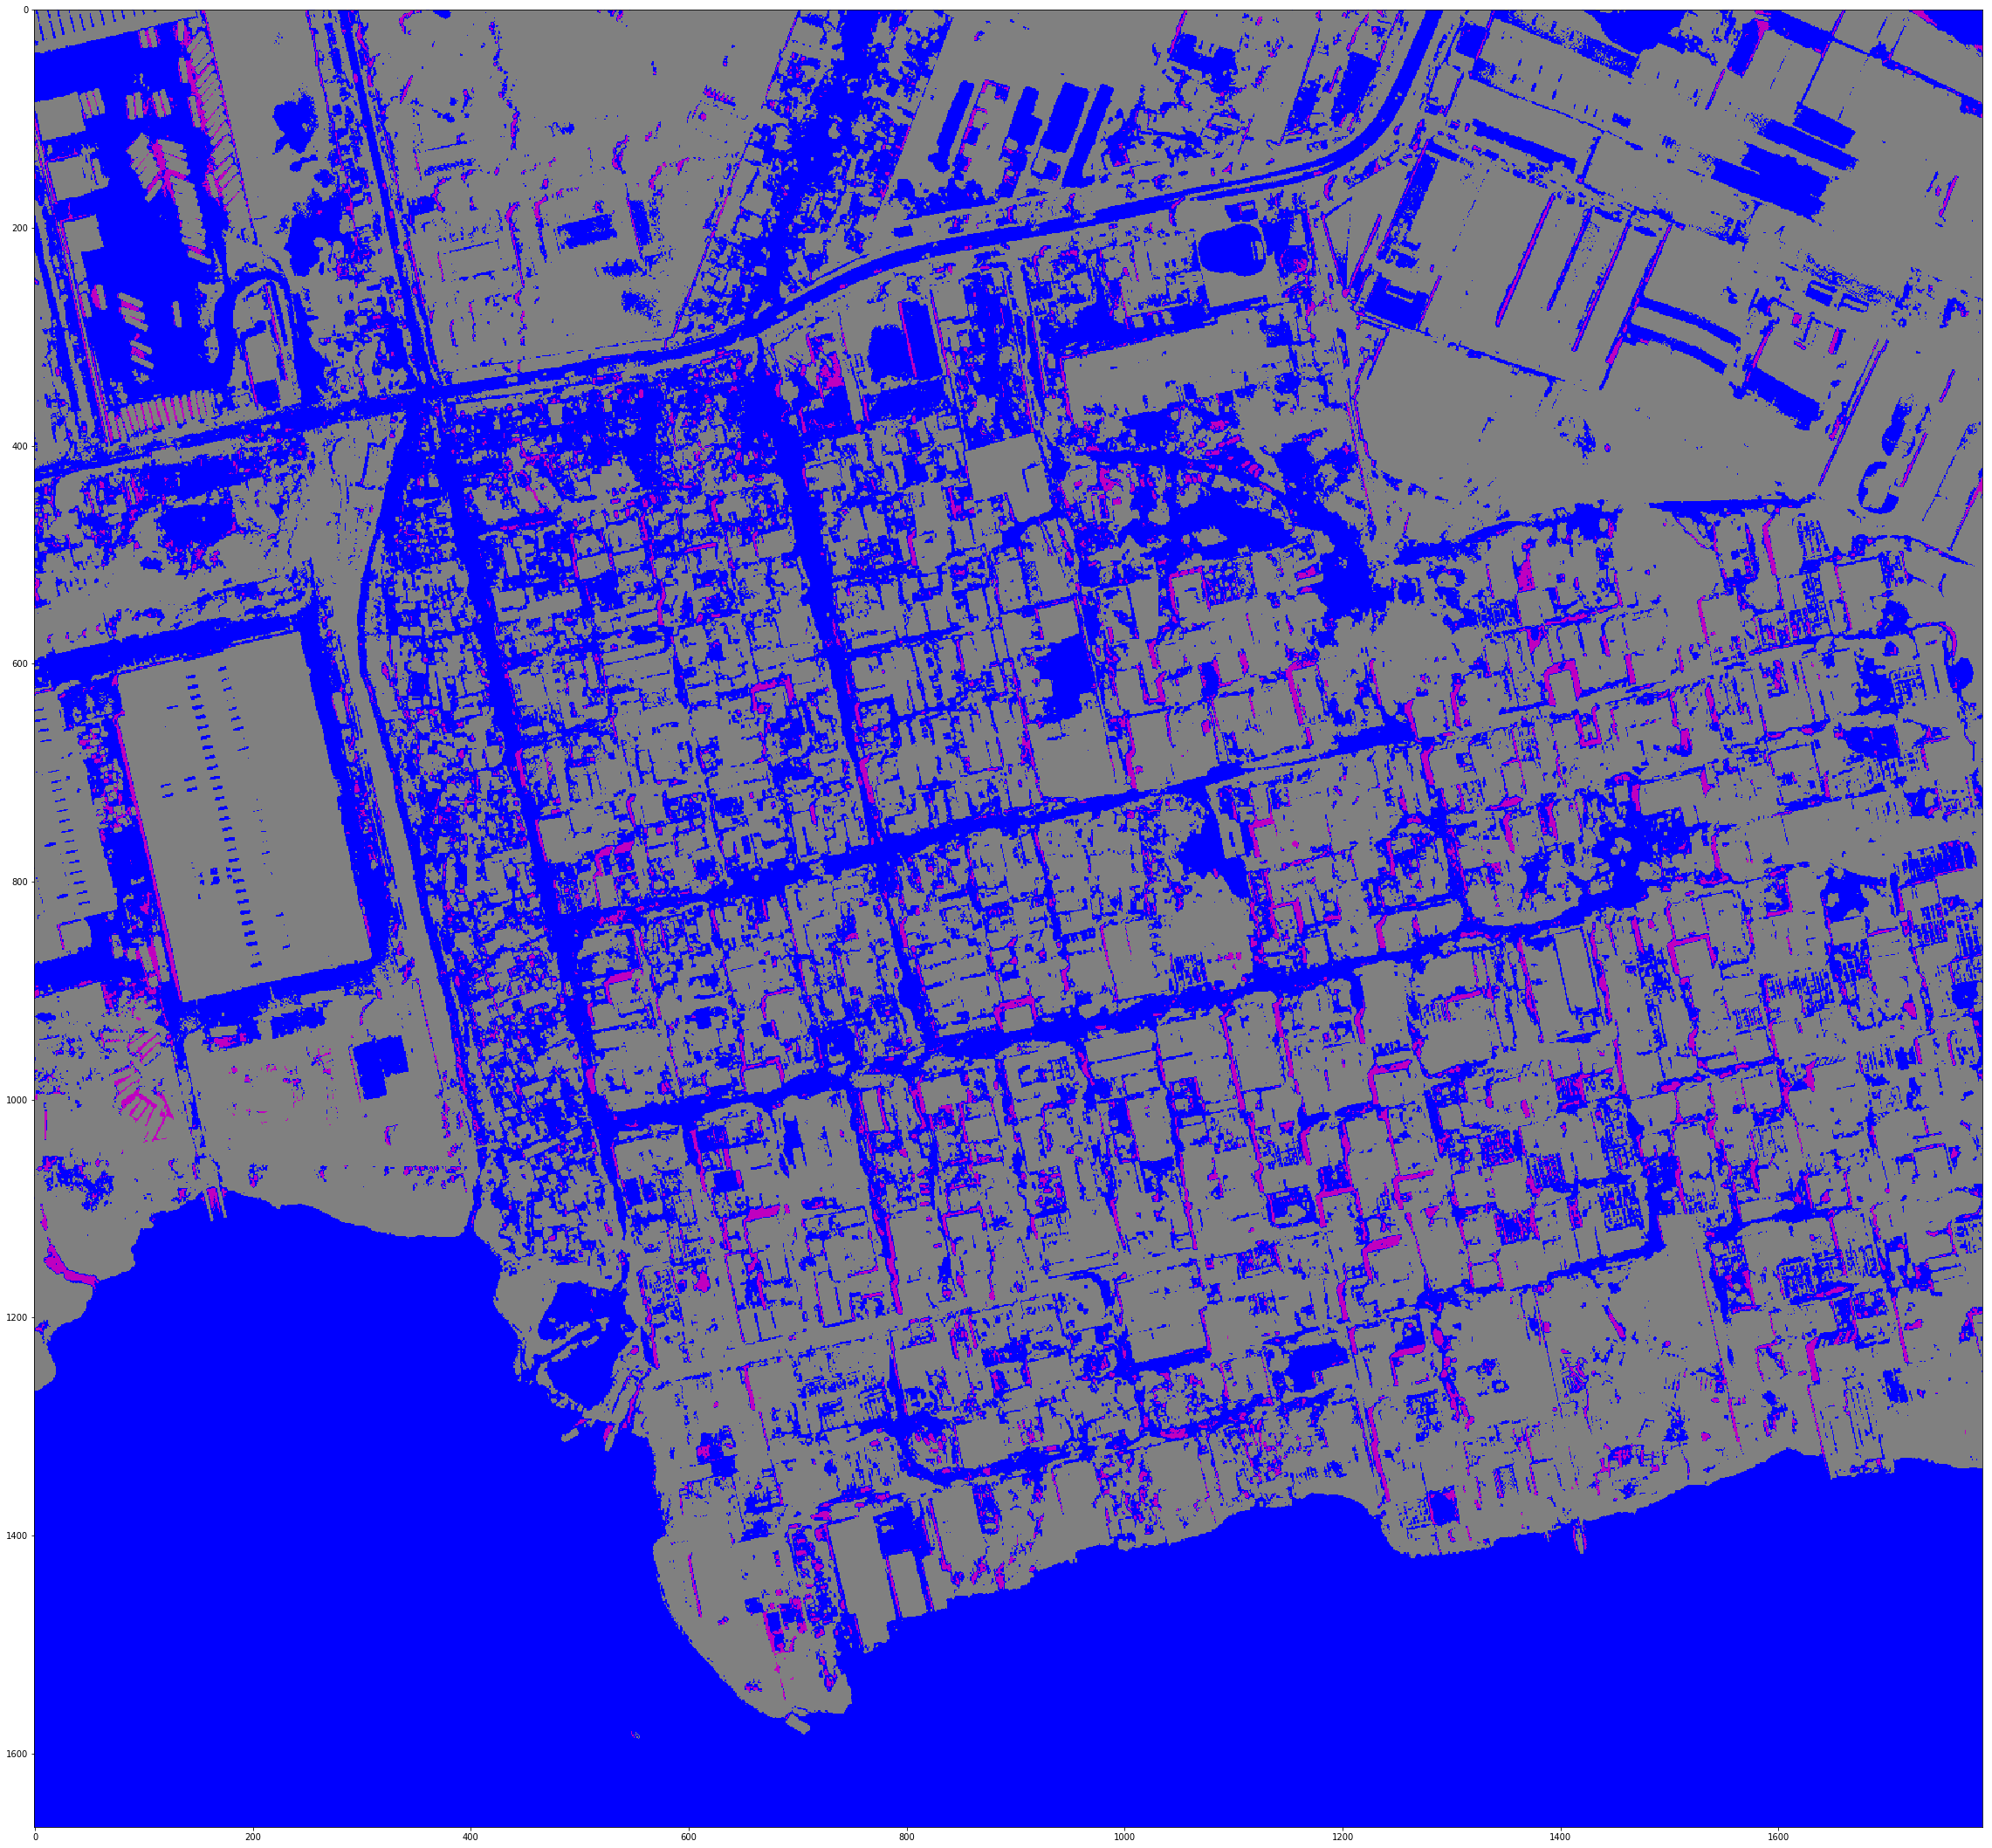

In [34]:
# Apply final random forest classifier to entire image
predictedClass_random_forest = loaded_clf_rf.predict(X_index)


# Plot random forest map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data_random_forest = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','grey'])
im = ax.imshow(pred_data_random_forest,cmap=cmap)
print(np.unique(pred_data))
plt.show()

In [35]:
# Write out random forest tif
with rio.open(svm_outputs_path+'random_forest_map.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_random_forest.astype('float32'),1)